## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
sns.axes_style({ 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True})

{'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

## Load results file

In [2]:
df1 = pd.read_csv('../data/active_learning/results_geva11_k8_LinearRegression_all.csv', parse_dates=['date'])
df2 = pd.read_csv('../data/active_learning/results_geva11_k8_random_forest_all.csv', parse_dates=['date'])
df3 = pd.read_csv('../data/active_learning/results_geva11_k8_xgboost_regressor_all.csv', parse_dates=['date'])
df4 = pd.read_csv('../data/active_learning/results_geva11_k8_mlp_regressor_all_nn.csv', parse_dates=['date'])
df = pd.concat([df1, df2, df3, df4], axis=0).rename(columns={'regressor':'Regressor', 'init':'Initialization'})
df.head(1)

,Regressor,method,list_type,date,query_idx,MSE,MAE,r2,time,Initialization
0,LinearRegression,greedy_distances,NaN,2020-01-16,"[30594, 16612, 2992, 31426, 19750, 12467, 6468...",32.407193,3.85471,-0.253455,0.0001,no_init


### Calculate random method

In [3]:
random_df = df[(df['method'] == 'random') & (df['list_type'] != 'init')].groupby(['Regressor', 'method', 'Initialization', 'date'])\
            .agg({'MSE':'mean', 'MAE':'mean', 'r2':'mean', 'time':'mean'}).reset_index()
df = pd.concat([df[((df['method'] == 'random') & (df['list_type'] != 'init')) == False], random_df], sort=True, axis=0)[list(df.columns)]

### Add init phase to the methods

In [4]:
to_append = [df[df['list_type'] != 'init']]
for init_phase in df['Initialization'].unique():
    df_init = df[(df['Initialization'] == init_phase) & (df['list_type'] == 'init')]
    for method, list_type in [(tup['method'], tup['list_type']) 
                              for tup in df[(df['Initialization'] == init_phase) & (df['list_type'] != 'init')]\
                              [['method', 'list_type']].drop_duplicates().to_dict('records')]:
        copy_df_init = df_init.copy()
        copy_df_init['method'] = method
        copy_df_init['list_type'] = list_type
        to_append.append(copy_df_init)
df = pd.concat(to_append, axis=0)

In [5]:
df.loc[df['list_type'].notna(), 'method'] += '_' + df.loc[df['list_type'].notna(), 'list_type'].drop(columns=['list_type'])
df = df.fillna({'list_type':'', 'query_idx':'[]'})
df['Initialization'] = df['Initialization'].str.replace('greedy_clustering_', 'greedy_clustering-')
df['Initialization'] = df['Initialization'].str.replace('greedy_distances_', 'greedy_distances-')
df['Initialization'] = df['Initialization'].str.replace('greedy_paretos_', 'greedy_paretos-')
df['Initialization'] = df['Initialization'].str.replace('random_', 'random-')
df['Init Method'] = df['Initialization'].str.split('-').str[0]
df['init_steps'] = df['Initialization'].str.split('-').str[1].fillna(0).astype(int)
df = df.sort_values(by=['Regressor', 'method', 'Init Method', 'init_steps', 'date'])

In [6]:
print(df['Init Method'].unique().tolist())

['greedy_clustering', 'greedy_distances', 'greedy_paretos', 'no_init', 'random']


### Adding Columns

In [7]:
df['Iter'] = df.groupby(['Regressor', 'method', 'Init Method', 'init_steps'])['time'].cumcount()+1
df['log_MSE'] = np.log(df['MSE'] + 1)
df['AUC'] = df.groupby(['Regressor', 'method', 'Init Method', 'init_steps'])['MSE'].cumsum()
df['logAUC'] = df.groupby(['Regressor', 'method', 'Init Method', 'init_steps'])['log_MSE'].cumsum()
df['prev_diff'] = df.groupby(['Regressor', 'method', 'Init Method', 'init_steps'])['MSE'].diff(1).values * -1
df['next_diff'] = df.groupby(['Regressor', 'method', 'Init Method', 'init_steps'])['MSE'].diff(-1).values
df['abs_diff'] = np.abs(df['prev_diff'])
df['abs_second_diff'] = np.abs(df['next_diff'] - df['prev_diff'])
df['ASD'] = (df.groupby(['Regressor', 'method', 'Init Method', 'init_steps'])['abs_second_diff'].cumsum()) / (df['Iter'] - 1)
df['w_abs_second_diff'] = df['abs_second_diff'] * df['Iter']
df['WASD'] = df.groupby(['Regressor', 'method', 'Init Method', 'init_steps'])['w_abs_second_diff'].cumsum() /\
                    df.groupby(['Regressor', 'method', 'Init Method', 'init_steps'])['Iter'].cumsum()
df['cum_time'] = df.groupby(['Regressor', 'method', 'Init Method', 'init_steps'])['time'].cumsum()
df = df[(df['method'] != 'pareto') & (df['Iter'] <= 100)]

In [8]:
df['Select Method'] = df['method'].str.replace('bootstrap', 'boot').str.replace('greedy_paretos', 'Pareto').str.replace('greedy_distances', 'Di')\
.str.replace('greedy_clustering', 'Cl').str.replace('greedy_predictions', 'Pr').str.replace('cluster_uncertainty', 'UCl')\
.str.replace('discretization_uncertainty', 'UDi').str.replace('qbc', 'QbC').str.replace('emcm', 'EMCM')\
.str.replace('mse_uncertainty', 'UMSE').str.replace('random', 'Random')
df['Initialization'] = df['Initialization'].str.replace('greedy_paretos', 'Pareto').str.replace('greedy_distances', 'Di')\
.str.replace('greedy_clustering', 'Cl').str.replace('random', 'Random').str.replace('no_init', 'None')
df['Init Method'] = df['Init Method'].str.replace('greedy_paretos', 'Pareto').str.replace('greedy_distances', 'Di')\
.str.replace('greedy_clustering', 'Cl').str.replace('random', 'Random').str.replace('no_init', 'None')
df['Regressor'] = df['Regressor'].str.replace('XGBRegressor', 'XGBoost').str.replace('Regressor', '')

In [9]:
df[df['Iter']==100].sort_values(by=['logAUC'], ascending=True).head(100)

,Regressor,method,list_type,date,query_idx,MSE,MAE,r2,time,Initialization,...,logAUC,prev_diff,next_diff,abs_diff,abs_second_diff,ASD,w_abs_second_diff,WASD,cum_time,Select Method
8750,RandomForest,emcm_bootstrap,bootstrap,2020-04-24,"[29264, 30601, 2495, 21813, 7179, 9995, 25956,...",8.672425,2.045298,0.664565,0.124218,Di-15,...,245.865610,0.139521,0.043901,0.139521,0.095620,0.984385,9.561968,0.375553,9.703423,EMCM_boot
31948,RandomForest,qbc_bootstrap,bootstrap,2020-04-24,"[21552, 18682, 21646, 24265, 19861, 9995, 3187...",8.550054,2.018876,0.669298,0.021153,Cl-15,...,247.489651,-0.080273,0.118744,0.080273,0.199017,0.443844,19.901677,0.237206,1.143017,QbC_boot
6151,RandomForest,qbc_bootstrap,bootstrap,2020-04-24,"[31314, 17795, 16016, 27681, 30601, 19803, 117...",8.270768,1.995714,0.680101,0.021713,Di-10,...,248.332324,0.123549,-0.039756,0.123549,0.163305,1.283602,16.330533,0.370018,1.130820,QbC_boot
26964,RandomForest,qbc_bootstrap,bootstrap,2020-04-24,"[4541, 9995, 17795, 10012, 29264, 20219, 27681...",9.384740,2.011821,0.637014,0.021715,Cl-5,...,248.516117,-0.130521,0.142178,0.130521,0.272699,0.410071,27.269900,0.177773,1.188559,QbC_boot
8664,RandomForest,qbc_models,models,2020-04-24,"[9995, 29264, 17795, 22831, 25532, 4058, 27681...",9.125107,2.008455,0.647056,0.020496,Di-15,...,248.525885,0.093814,0.100177,0.093814,0.006363,0.891125,0.636306,0.293152,1.103558,QbC_models
38649,RandomForest,qbc_bootstrap,bootstrap,2020-04-24,"[27681, 29264, 22463, 16205, 14209, 19173, 235...",8.957603,2.032794,0.653535,0.021655,Random-5,...,248.811337,0.103920,-0.178002,0.103920,0.281922,0.434684,28.192209,0.208460,1.151272,QbC_boot
10875,RandomForest,qbc_bootstrap,bootstrap,2020-04-24,"[29989, 3454, 7632, 21646, 29264, 13345, 8511,...",8.641337,2.043285,0.665768,0.021853,Di-20,...,248.911064,0.047025,0.012447,0.047025,0.034578,1.114195,3.457774,0.393695,1.152921,QbC_boot
907,RandomForest,qbc_bootstrap,bootstrap,2020-04-24,"[29264, 10120, 27681, 17795, 16916, 1860, 1042...",8.537287,2.061507,0.669792,0.024619,None,...,249.236670,0.013856,0.071407,0.013856,0.057551,1.001502,5.755084,0.332755,1.247266,QbC_boot
8578,RandomForest,qbc_bootstrap,bootstrap,2020-04-24,"[31390, 27681, 27893, 16300, 24621, 4541, 1613...",8.406098,2.055278,0.674866,0.020789,Di-15,...,249.327333,-0.096424,0.144311,0.096424,0.240735,0.926316,24.073481,0.348279,1.175325,QbC_boot
32120,RandomForest,emcm_bootstrap,bootstrap,2020-04-24,"[29264, 9995, 3084, 26829, 17795, 19984, 23790...",9.028301,2.050911,0.650801,0.126563,Cl-15,...,250.156257,0.083676,0.019502,0.083676,0.064174,0.419222,6.417358,0.223626,9.484737,EMCM_boot


In [10]:
init_sorter = ['Pareto', 'Cl', 'Di', 'Random', 'None']
method_sorter = ['greedy_clustering', 'greedy_distances', 'greedy_paretos', 'pareto', 'greedy_predictions',
                 'cluster_uncertainty', 'discretization_uncertainty', 'mse_uncertainty',
                 'emcm_bootstrap', 'emcm_models', 'qbc_bootstrap', 'qbc_models', 'random']

## Section 6.3

<Figure size 720x288 with 0 Axes>

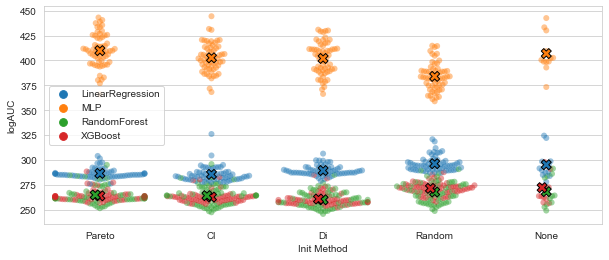

In [11]:
plt.figure(figsize=(10, 4))

fig, ax = plt.subplots(figsize=(25,4.8))
sns.swarmplot(x="Init Method", y="logAUC", hue="Regressor", 
              order=init_sorter,data=df[df['Iter'] == 100], dodge=False, size=6, alpha=0.45, ax=ax)
ax = sns.swarmplot(x="Init Method", y="logAUC", hue="Regressor", 
              order=init_sorter,data=df[df['Iter'] == 100].groupby(['Init Method', 'Regressor']).agg({'logAUC':'mean'}).reset_index(), marker='X', edgecolor='black',dodge=False, linewidth=1, size=10, ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4], labels[0:4], loc=0)
fig.set_size_inches(10,4)

In [12]:
df[df['Iter']==100]['Init Method'].unique()

array(['Cl', 'Di', 'Pareto', 'None', 'Random'], dtype=object)

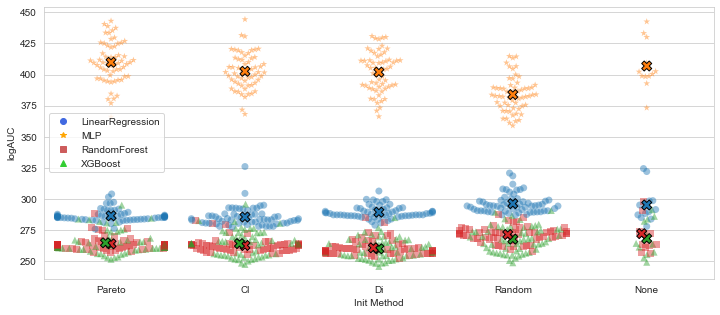

<Figure size 432x288 with 0 Axes>

In [15]:
############## Begin hack ##############
from matplotlib.axes._axes import Axes
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D
from seaborn import color_palette

############## Begin hack ##############
class CM():
    def __init__(self, markers=["^", "s", 'o', '*']):
        self.marker = np.array(markers)
        self.colors = []

    def get_markers_for_colors(self, c):
        for _co in c:
            if not any((_co == x).all() for x in self.colors):
                self.colors.append(_co)
        ind = np.array([np.where((self.colors == row).all(axis=1)) \
                        for row in c]).flatten()
        return self.marker[ind % len(self.marker)]

    def get_legend_handles(self, **kwargs):
        return [plt.Line2D([0],[0], ls="none", marker=m, color=c, mec="none", **kwargs) \
                for m,c in zip(self.marker, self.colors)]

from matplotlib.axes._axes import Axes
import matplotlib.markers as mmarkers
cm = CM()


old_scatter = Axes.scatter

def new_scatter(self, *args, **kwargs):
    sc = old_scatter(self, *args, **kwargs)
    c = kwargs.get("c", None)
    if isinstance(c, np.ndarray):
        m = cm.get_markers_for_colors(c)
        paths = []
        for _m in m:
            marker_obj = mmarkers.MarkerStyle(_m)
            paths.append(marker_obj.get_path().transformed(
                        marker_obj.get_transform()))
        sc.set_paths(paths)
    return sc

Axes.scatter = new_scatter
############## End hack. ##############

fig, ax = plt.subplots(figsize=(25,4.8))
sns.swarmplot(x="Init Method", y="logAUC", hue="Regressor", palette='tab10',
              order=init_sorter,data=df[df['Iter'] == 100], dodge=False, size=7, alpha=0.45, ax=ax)
Axes.scatter = old_scatter
ax = sns.swarmplot(x="Init Method", y="logAUC", hue="Regressor", palette='tab10',
              order=init_sorter, data=df[df['Iter'] == 100].groupby(['Init Method', 'Regressor']).agg({'logAUC':'mean'}).reset_index(),
                   marker='X', edgecolor='black',dodge=False, linewidth=1, size=10, ax=ax)
handles, labels = ax.get_legend_handles_labels()
def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc=color, mec=color, marker=label)
    return line

duplicates = [dupe_legend(mark, color) for mark, color in [('o', 'royalblue'), ('*', 'orange'), ('s', 'indianred'), ('^', 'limegreen')]]
ax.legend(duplicates, labels, loc=0)
fig.set_size_inches(12,5)
plt.show()
plt.savefig('plots/regressors_comparison_mlp.eps', format='eps')

In [17]:
df[df['Iter'] == 100].groupby(['Init Method', 'Regressor']).agg({'logAUC':'mean'}).reset_index().to_csv('regressors_comparison.csv', index=False)

In [15]:
Axes.scatter = old_scatter

<Figure size 720x288 with 0 Axes>

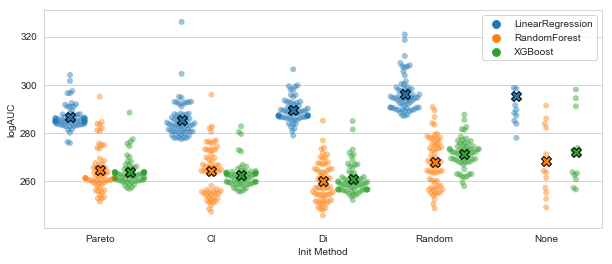

In [16]:
plt.figure(figsize=(10, 4))

fig, ax = plt.subplots(figsize=(25,4.8))
sns.swarmplot(x="Init Method", y="logAUC", hue="Regressor", 
              order=init_sorter,data=df[df['Iter'] == 100], dodge=True, size=6, alpha=0.45, ax=ax)
ax = sns.swarmplot(x="Init Method", y="logAUC", hue="Regressor", 
              order=init_sorter,data=df[df['Iter'] == 100].groupby(['Init Method', 'Regressor']).agg({'logAUC':'mean'}).reset_index(), marker='X', edgecolor='black',dodge=True, linewidth=1, size=10, ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3], loc=1)
fig.set_size_inches(10,4)

<Figure size 720x288 with 0 Axes>

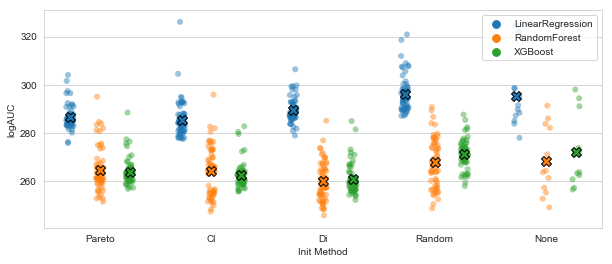

In [17]:
plt.figure(figsize=(10, 4))

fig, ax = plt.subplots(figsize=(25,4.8))
sns.stripplot(x="Init Method", y="logAUC", hue="Regressor", 
              order=init_sorter,data=df[df['Iter'] == 100], dodge=True, size=6, alpha=0.45, ax=ax)
ax = sns.swarmplot(x="Init Method", y="logAUC", hue="Regressor", 
              order=init_sorter,data=df[df['Iter'] == 100].groupby(['Init Method', 'Regressor']).agg({'logAUC':'mean'}).reset_index(), marker='X', edgecolor='black',dodge=True, linewidth=1, size=10, ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3], loc=1)
fig.set_size_inches(10,4)

In [18]:
top1 = df[df['Iter'] == 100].sort_values(by='logAUC').groupby(['Regressor', 'Init Method', 'init_steps']).head(1).sort_values(by=['Regressor', 'Init Method', 'init_steps'])[['Regressor', 'Init Method', 'init_steps', 'method', 'Select Method']].drop_duplicates()
top1

,Regressor,Init Method,init_steps,method,Select Method
26772,LinearRegression,Cl,5,greedy_clustering,Cl
28793,LinearRegression,Cl,10,greedy_distances,Di
31776,LinearRegression,Cl,15,greedy_clustering,Cl
34083,LinearRegression,Cl,20,greedy_clustering,Cl
36260,LinearRegression,Cl,25,greedy_clustering,Cl
3402,LinearRegression,Di,5,greedy_clustering,Cl
5969,LinearRegression,Di,10,greedy_clustering,Cl
8406,LinearRegression,Di,15,greedy_clustering,Cl
10308,LinearRegression,Di,20,greedy_predictions,Pr
12890,LinearRegression,Di,25,greedy_clustering,Cl


In [19]:
top5 = df[df['Iter'] == 100].sort_values(by='logAUC').groupby(['Regressor', 'Init Method', 'init_steps']).head(5).sort_values(by=['Regressor', 'Init Method', 'init_steps'])[['Regressor', 'Init Method', 'init_steps', 'method', 'Select Method']].drop_duplicates()

## Section 6.3.1 - selecting the initialization method + steps

In [20]:
best_regressor = 'RandomForest'

In [21]:
regressors = df['Regressor'].unique().tolist()
inits_methods = df['Init Method'].unique().tolist()
methods = df['method'].unique().tolist()
print(regressors)
print(inits_methods)
print(methods)

['LinearRegression', 'RandomForest', 'XGBoost']
['Cl', 'Di', 'Pareto', 'None', 'Random']
['cluster_uncertainty', 'discretization_uncertainty', 'emcm_bootstrap', 'emcm_models', 'greedy_clustering', 'greedy_distances', 'greedy_paretos', 'greedy_predictions', 'mse_uncertainty', 'qbc_bootstrap', 'qbc_models', 'random']


In [22]:
init_df = pd.merge(df, top5).sort_values(by=['Regressor', 'Init Method', 'init_steps', 'Iter', 'MSE'], ascending=True)\
            .groupby(['Regressor', 'Init Method', 'init_steps', 'Initialization', 'Iter'])\
            .agg({'MSE':'mean', 'MAE':'mean', 'abs_diff':'mean', 'AUC':'mean', 'logAUC':'mean', 'ASD':'mean', 'WASD':'mean'}).reset_index()
init_df['initcat'] = init_df['Init Method'].astype("category")
init_df['initcat'].cat.set_categories(init_sorter, inplace=True)
init_df = init_df.sort_values(by=['Regressor', 'initcat', 'init_steps', 'Iter'])
init_df.to_csv('../data/active_learning/final_results/init_df.csv', index=False)
init_df.head()

,Regressor,Init Method,init_steps,Initialization,Iter,MSE,MAE,abs_diff,AUC,logAUC,ASD,WASD,initcat
1100,LinearRegression,Pareto,5,Pareto-5,1,43.256686,5.006440,NaN,43.256686,3.790006,NaN,NaN,Pareto
1101,LinearRegression,Pareto,5,Pareto-5,2,47.969781,5.002674,4.713094,91.226467,7.681210,6.265498,4.176999,Pareto
1102,LinearRegression,Pareto,5,Pareto-5,3,58.948373,5.761970,10.978592,150.174840,11.774694,232.767600,231.723351,Pareto
1103,LinearRegression,Pareto,5,Pareto-5,4,529.196668,12.822809,470.248295,679.371508,18.047942,471.676293,518.831481,Pareto
1104,LinearRegression,Pareto,5,Pareto-5,5,49.951285,4.504683,479.245383,729.322793,21.978812,470.365128,501.364866,Pareto


In [23]:
pivots = []
for regressor in ['LinearRegression', 'RandomForest', 'XGBoost']:
    pivot = init_df[(init_df['Iter'].isin([5, 10, 15, 20, 25, 50, 75, 100])) & (init_df['Regressor'] == regressor)]\
               .pivot_table(index=['Init Method', 'init_steps'], columns='Iter', values='MSE')
    pivot = pivot.join(init_df[(init_df['Regressor'] == regressor)]\
                       .groupby(['Init Method', 'init_steps']).agg({'AUC':'last', 'logAUC':'last', 'ASD':'last', 'WASD':'last'}))
    pivot['Regressor'] = regressor
    pivots.append(pivot)
pivots = pd.concat(pivots, axis=0).reset_index()
pivots['initcat'] = pivots['Init Method'].astype("category")
pivots['initcat'].cat.set_categories(init_sorter, inplace=True)
pivots = pivots.sort_values(by=['initcat', 'init_steps', 'Regressor'])[['Regressor', 'Init Method', 'init_steps', 5, 10, 15, 20, 25, 50, 75, 100, 'AUC', 'logAUC', 'ASD', 'WASD']]
pivots.to_csv('../data/active_learning/final_results/init_df_pivot.csv', index=False)
pivots

,Regressor,Init Method,init_steps,5,10,15,20,25,50,75,100,AUC,logAUC,ASD,WASD
11,LinearRegression,Pareto,5,49.951285,24.238447,21.132723,17.667961,17.244787,12.801389,11.910104,11.762104,2127.579534,280.716637,19.637405,1.698769
32,RandomForest,Pareto,5,22.636028,20.037304,21.893618,14.320782,13.843132,10.348656,9.888936,9.691121,1271.194500,257.389879,0.958148,0.359149
53,XGBoost,Pareto,5,24.640606,19.159597,16.904157,15.220237,14.025724,11.731782,9.852349,9.661282,1282.633295,259.207306,0.774682,0.505760
12,LinearRegression,Pareto,10,49.951285,31.471365,24.957080,20.957003,18.502883,12.654009,11.716930,11.549867,2181.591839,283.067832,19.695768,1.699268
33,RandomForest,Pareto,10,22.636028,22.829951,17.640661,14.170665,13.777285,10.377361,9.832336,9.321893,1262.569361,256.385623,0.973776,0.401154
54,XGBoost,Pareto,10,24.640606,24.295833,19.400762,14.724987,13.791983,11.371514,9.689514,9.452124,1317.554657,260.802439,0.923766,0.554497
13,LinearRegression,Pareto,15,49.951285,31.471365,28.621828,20.708198,17.460342,12.819867,12.131550,11.627213,2203.581439,284.297768,19.743129,1.739483
34,RandomForest,Pareto,15,22.636028,22.829951,32.116192,14.746527,13.699490,10.568180,9.903309,9.538161,1311.789825,259.735914,0.954449,0.430762
55,XGBoost,Pareto,15,24.640606,24.295833,20.805833,16.121694,13.894788,11.122409,9.943411,9.496344,1326.927888,261.513993,0.950304,0.559927
14,LinearRegression,Pareto,20,49.951285,31.471365,28.621828,21.473231,17.922308,12.585557,11.819093,11.501841,2194.562778,283.329869,19.714124,1.725752


In [24]:
float_cols = [5, 10, 15, 20, 25, 50, 75, 100, 'AUC', 'logAUC', 'ASD', 'WASD']
pivots[pivots['Regressor'] == best_regressor].drop(columns=['Regressor']).style.highlight_min().format({x:"{:.2f}" for x in float_cols})

,Init Method,init_steps,5,10,15,20,25,50,75,100,AUC,logAUC,ASD,WASD
32,Pareto,5,22.64,20.04,21.89,14.32,13.84,10.35,9.89,9.69,1271.19,257.39,0.96,0.36
33,Pareto,10,22.64,22.83,17.64,14.17,13.78,10.38,9.83,9.32,1262.57,256.39,0.97,0.40
34,Pareto,15,22.64,22.83,32.12,14.75,13.70,10.57,9.90,9.54,1311.79,259.74,0.95,0.43
35,Pareto,20,22.64,22.83,32.12,16.55,12.31,10.10,9.87,9.55,1290.84,257.75,0.88,0.39
36,Pareto,25,22.64,22.83,32.12,16.55,15.68,10.45,10.01,9.60,1325.33,260.33,0.98,0.46
21,Cl,5,22.08,19.41,22.25,12.77,12.04,10.43,9.55,9.30,1220.51,253.40,0.97,0.37
22,Cl,10,22.08,17.98,22.54,13.73,12.23,10.37,9.74,9.18,1245.62,254.60,1.13,0.41
23,Cl,15,22.08,17.98,14.69,13.49,11.87,10.32,9.50,9.20,1187.30,251.82,0.49,0.27
24,Cl,20,22.08,17.98,14.69,15.54,12.49,10.65,10.00,9.83,1236.77,256.00,0.46,0.26
25,Cl,25,22.08,17.98,14.69,15.54,14.70,10.61,9.88,9.75,1243.31,256.38,0.54,0.31


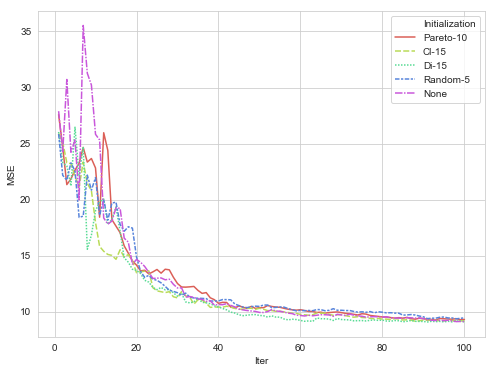

In [25]:
plt.figure(figsize=(8, 6))
init_df_iters = init_df[init_df['Initialization'].isin(['None', 'Random-5', 'Cl-15',
                                              'Di-15', 'Pareto-10']) & (init_df['Regressor'] == best_regressor)]
sns.lineplot(data=init_df_iters[init_df_iters['Regressor'] == best_regressor], x='Iter', y='MSE', hue='Initialization', style='Initialization', palette='hls', ci=None, legend='brief')

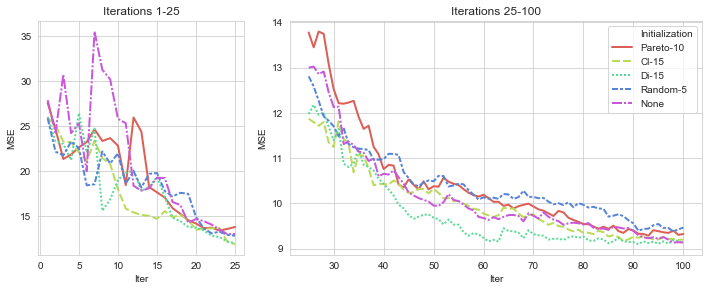

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2]})
sns.lineplot(data=init_df_iters[init_df_iters['Iter'] <= 25], x='Iter', y='MSE', hue='Initialization', size='Initialization', style='Initialization', sizes=(2,2), palette='hls', ci=None, legend=False, ax=axes[0])
sns.lineplot(data=init_df_iters[init_df_iters['Iter'] >= 25], x='Iter', y='MSE', hue='Initialization', size='Initialization', style='Initialization', sizes=(2,2), palette='hls', ci=None, legend='brief', ax=axes[1])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
axes[0].set_title('Iterations 1-25')
axes[1].set_title('Iterations 25-100')
plt.show()

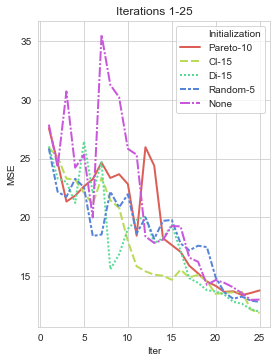

In [93]:
fig, axes = plt.subplots(1, 1, figsize=(4, 5))
sns.lineplot(data=init_df_iters[init_df_iters['Iter'] <= 25], x='Iter', y='MSE', hue='Initialization', size='Initialization', style='Initialization', sizes=(2,2), palette='hls', ci=None, legend='brief', ax=axes)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
axes.set_title('Iterations 1-25')
plt.savefig('plots/init_methods_comparison_1_25.eps', format='eps')

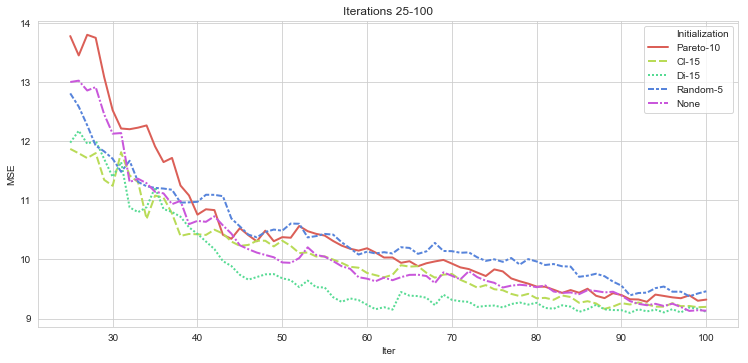

In [91]:
fig, axes = plt.subplots(1, 1, figsize=(10.5, 5))
sns.lineplot(data=init_df_iters[init_df_iters['Iter'] >= 25], x='Iter', y='MSE', hue='Initialization', size='Initialization', style='Initialization', sizes=(2,2), palette='hls', ci=None, legend='brief', ax=axes)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
axes.set_title('Iterations 25-100')
plt.savefig('plots/init_methods_comparison_25_100.eps', format='eps')

In [126]:
best_init = 'Di-15'

## Section 6.3.2 - selecting the selection method

In [230]:
df['reg_init_method'] = df['Regressor'] + '#' + df['Initialization'] + '#' + df['method']

epsilon = 0.25
def calculate_FTC(x):
    converged = (x < epsilon).tolist()[::-1]
    n = len(converged)
    for i, val in enumerate(converged):
        if not val:
            return n - i
    else:
        return n

measures = df.groupby(['Regressor', 'Initialization', 'Init Method', 'init_steps', 'method', 'Select Method', 'reg_init_method'])\
.agg({'AUC':'max', 'logAUC':'max', 'ASD':'last', 'WASD':'last', 'abs_diff':calculate_FTC}).reset_index().rename(columns={'abs_diff':'FTC'})
mses = df[df['Iter'].isin([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])].pivot(index='reg_init_method', columns='Iter', values='MSE')
# maes = df[df['Iter'].isin([10, 20, 40, 60, 80, 100])].pivot(index='reg_init_method', columns='Iter', values='MAE')
# summary = pd.merge( measures, pd.merge(mses, maes, on='reg_init_method', suffixes=('_MSE', '_MAE')), on='reg_init_method')\
summary = pd.merge(measures, mses, on='reg_init_method').drop(columns='reg_init_method')
summary['initcat'] = summary['Init Method'].astype("category")
summary['initcat'].cat.set_categories(init_sorter, inplace=True)
summary['methodcat'] = summary['method'].astype("category")
summary['methodcat'].cat.set_categories(method_sorter, inplace=True)
summary = summary.sort_values(by=['Regressor', 'initcat', 'init_steps', 'methodcat'])
summary.to_csv('../data/active_learning/final_results/summary.csv', index=False)
summary

,Regressor,Initialization,Init Method,init_steps,method,Select Method,AUC,logAUC,ASD,WASD,...,30,40,50,60,70,80,90,100,initcat,methodcat
184,LinearRegression,Pareto-5,Pareto,5,greedy_clustering,Cl,2069.979745,276.339867,19.593408,1.659863,...,16.014097,13.184609,11.839920,11.476187,11.210062,11.201330,11.313741,11.293087,Pareto,greedy_clustering
185,LinearRegression,Pareto-5,Pareto,5,greedy_distances,Di,2196.370885,283.464583,19.873109,1.742578,...,19.092370,15.007014,12.455483,12.192196,11.705595,11.302814,11.116121,11.244496,Pareto,greedy_distances
186,LinearRegression,Pareto-5,Pareto,5,greedy_paretos,Pareto,2225.276165,285.114430,19.711499,1.723117,...,18.834269,14.677956,12.780706,12.251078,11.649693,11.615754,11.409276,11.415549,Pareto,greedy_paretos
187,LinearRegression,Pareto-5,Pareto,5,greedy_predictions,Pr,2158.581291,283.125046,19.573010,1.695001,...,14.697832,13.983089,13.770479,13.136248,13.269259,12.632935,12.465909,12.209137,Pareto,greedy_predictions
180,LinearRegression,Pareto-5,Pareto,5,cluster_uncertainty,UCl,2281.988510,286.121127,20.358873,1.768779,...,17.425056,15.319011,13.192808,12.377153,11.692970,11.517875,11.511030,11.409761,Pareto,cluster_uncertainty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,XGBoost,None,None,0,emcm_bootstrap,EMCM_boot,1427.953028,260.855326,3.133720,0.787787,...,12.988423,11.948815,11.805889,10.459625,9.967898,9.437278,9.166605,9.465182,None,emcm_bootstrap
627,XGBoost,None,None,0,emcm_models,EMCM_models,1264.166797,257.333626,1.064121,0.584052,...,15.189759,11.788738,11.394481,9.947234,10.222753,9.454594,8.756188,9.047346,None,emcm_models
633,XGBoost,None,None,0,qbc_bootstrap,QbC_boot,1528.926687,273.823580,1.606431,0.757856,...,16.431450,15.181732,12.055464,11.645368,11.054244,10.671958,10.617625,10.352563,None,qbc_bootstrap
634,XGBoost,None,None,0,qbc_models,QbC_models,1823.005218,263.374257,16.109450,1.353446,...,12.347306,11.041200,10.589929,10.625678,9.715943,9.552836,9.333203,9.731487,None,qbc_models


In [231]:
summary[(summary['Regressor'] == best_regressor) & (summary['Initialization'] == best_init)]\
[['Select Method',20, 30, 40, 50, 60, 70, 80, 90, 100, 'AUC', 'logAUC', 'ASD','WASD', 'FTC']].style.highlight_min().format({x:"{:.2f}" for x in [20, 30, 40, 50, 60, 70, 80, 90, 100, 'AUC', 'logAUC', 'ASD']})

,Select Method,20,30,40,50,60,70,80,90,100,AUC,logAUC,ASD,WASD,FTC
328,Cl,16.39,12.22,11.89,10.72,10.64,10.71,10.67,10.46,10.25,1315.11,261.76,0.98,0.343069,54
329,Di,17.25,13.89,10.96,10.10,9.25,9.88,9.78,9.89,9.49,1267.56,257.34,1.14,0.422171,69
330,Pareto,18.33,12.26,11.46,10.70,10.16,10.42,10.31,10.15,10.22,1294.59,259.56,1.12,0.457206,70
331,Pr,17.77,17.82,10.42,10.52,9.65,9.48,9.45,9.28,9.53,1278.00,257.50,1.40,0.539872,57
324,UCl,17.54,15.30,11.89,11.25,10.80,10.78,10.55,10.24,10.56,1336.36,263.33,0.92,0.309082,42
325,UDi,20.54,15.20,12.82,12.14,12.14,11.96,11.86,11.63,10.96,1430.77,270.07,1.15,0.455877,91
332,UMSE,15.56,12.74,12.70,10.89,10.93,10.38,10.21,9.67,9.90,1295.26,260.08,0.90,0.312504,85
326,EMCM_boot,13.01,11.34,9.69,8.72,8.86,8.59,8.87,8.62,8.67,1127.48,245.87,0.98,0.375553,95
327,EMCM_models,12.63,10.60,11.16,10.65,9.57,9.58,9.27,9.49,9.88,1186.87,251.70,0.91,0.336971,99
333,QbC_boot,13.52,10.93,10.11,9.64,9.40,9.56,9.44,8.88,8.41,1164.28,249.33,0.93,0.348279,85


In [129]:
summary[(summary['Regressor'] == 'LinearRegression') & (summary['Initialization'] == 'Cl-15')]\
[['Select Method', 30, 40, 50, 60, 70, 80, 90, 100, 'AUC', 'logAUC', 'ASD', 'WASD','FTC']].style.highlight_min().format({x:"{:.2f}" for x in [30, 40, 50, 60, 70, 80, 90, 100, 'AUC', 'logAUC', 'ASD']})

,Select Method,30,40,50,60,70,80,90,100,AUC,logAUC,ASD,WASD,FTC
16,Cl,14.37,13.01,11.91,11.51,11.23,11.21,11.29,11.26,2133.36,278.06,4.95,0.368641,54
17,Di,14.56,13.38,12.35,11.97,11.53,11.37,11.14,11.25,2162.97,280.08,4.99,0.404993,75
18,Pareto,14.35,12.98,11.68,11.64,11.18,11.24,11.22,11.30,2161.25,279.54,5.02,0.421346,75
19,Pr,13.16,12.57,12.28,12.02,12.03,11.74,11.63,11.60,2144.08,279.16,5.14,0.460337,81
12,UCl,15.50,13.62,12.66,13.25,12.54,11.99,11.71,11.58,2211.41,283.66,4.99,0.409542,91
13,UDi,15.61,13.63,14.62,15.62,14.61,14.46,14.08,14.32,2345.25,292.97,5.07,0.497293,92
20,UMSE,15.74,13.86,13.16,13.12,13.17,13.27,13.08,13.03,2276.28,288.13,4.98,0.408797,99
14,EMCM_boot,13.84,13.31,12.94,12.93,13.02,12.74,12.39,12.33,2180.95,282.07,5.02,0.434822,98
15,EMCM_models,13.70,13.52,12.47,11.82,11.59,11.75,11.77,11.64,2139.48,278.90,5.03,0.408832,70
21,QbC_boot,14.06,13.48,12.80,12.83,12.66,12.70,12.50,12.52,2198.94,283.24,4.97,0.386921,69


#### Plots

In [130]:
df['method'].unique()

array(['cluster_uncertainty', 'discretization_uncertainty',
       'emcm_bootstrap', 'emcm_models', 'greedy_clustering',
       'greedy_distances', 'greedy_paretos', 'greedy_predictions',
       'mse_uncertainty', 'qbc_bootstrap', 'qbc_models', 'random'],
      dtype=object)

In [131]:
df['method_type'] = 10
df.loc[df['method'].isin(['random']) ,'method_type'] = 0
df.loc[df['method'].isin(['greedy_clustering', 'greedy_distances', 'greedy_paretos', 'greedy_predictions', 'mse_uncertainty', 'cluster_uncertainty', 'discretization_uncertainty']) ,'method_type'] = 1
df.loc[df['method'].isin(['emcm_models', 'qbc_models', 'emcm_bootstrap', 'qbc_bootstrap']) ,'method_type'] = 2

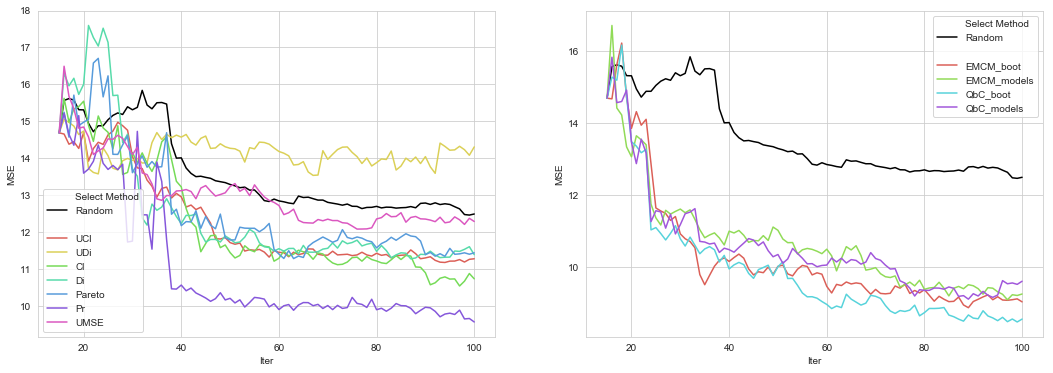

In [132]:
df_to_plot = df[(df['Regressor'] == best_regressor) & (df['Initialization'] == 'Cl-15') & (df['Iter'] >= df['init_steps'])]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(data=df_to_plot[df_to_plot['method_type'] == 0], x='Iter', y='MSE', hue='Select Method', palette=['black'], ci=None, legend='brief', ax=axes[0])
sns.lineplot(data=df_to_plot[df_to_plot['method_type'] == 1], x='Iter', y='MSE', hue='Select Method', palette='hls', ci=None, legend='brief', ax=axes[0])
legend = axes[0].legend()
legend.texts[2].set_text("")
sns.lineplot(data=df_to_plot[df_to_plot['method_type'] == 0], x='Iter', y='MSE', hue='Select Method', palette=['black'], ci=None, legend='brief', ax=axes[1])
sns.lineplot(data=df_to_plot[df_to_plot['method_type'] == 2], x='Iter', y='MSE', hue='Select Method', palette='hls',ci=None, legend='brief', ax=axes[1])
legend = axes[1].legend()
legend.texts[2].set_text("")
plt.show()

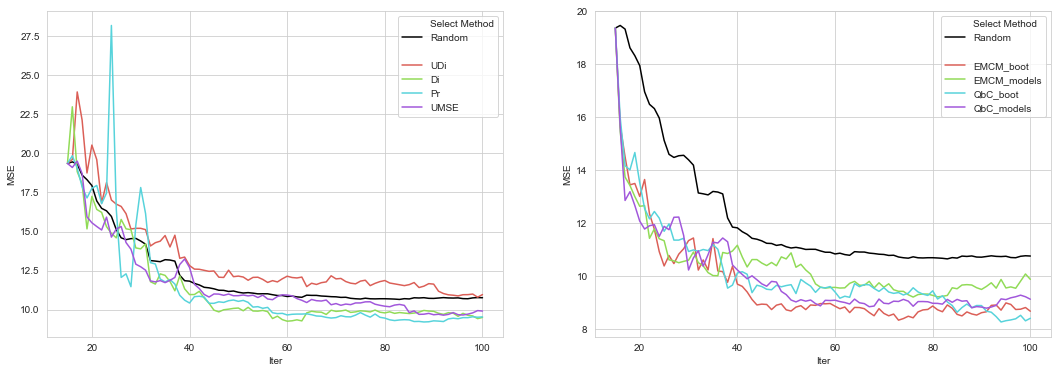

In [133]:
df_to_plot = df[(df['Regressor'] == best_regressor) & (df['Initialization'] == best_init) & (df['Iter'] >= df['init_steps'])]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(data=df_to_plot[df_to_plot['method_type'] == 0], x='Iter', y='MSE', hue='Select Method', palette=['black'], ci=None, legend='brief', ax=axes[0])
sns.lineplot(data=df_to_plot[df_to_plot['method'].isin(['greedy_distances', 'greedy_predictions', 'mse_uncertainty', 'discretization_uncertainty'])], x='Iter', y='MSE', hue='Select Method', palette='hls', ci=None, legend='brief', ax=axes[0])
legend = axes[0].legend()
legend.texts[2].set_text("")
sns.lineplot(data=df_to_plot[df_to_plot['method_type'] == 0], x='Iter', y='MSE', hue='Select Method', palette=['black'], ci=None, legend='brief', ax=axes[1])
sns.lineplot(data=df_to_plot[df_to_plot['method_type'] == 2], x='Iter', y='MSE', hue='Select Method', palette='hls',ci=None, legend='brief', ax=axes[1])
legend = axes[1].legend()
legend.texts[2].set_text("")
plt.show()

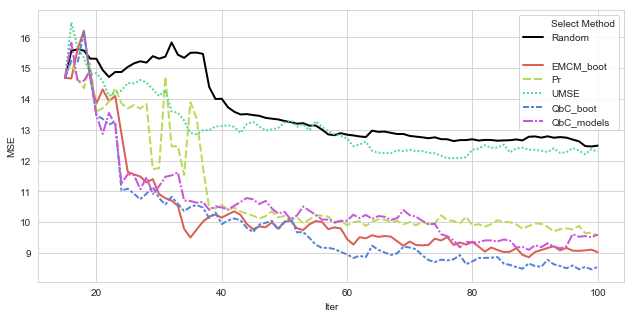

In [134]:
# checking Cl-15

df_to_plot = df[(df['Regressor'] == best_regressor) & (df['Initialization'] == 'Cl-15') & (df['Iter'] >= df['init_steps'])]
fig, ax = plt.subplots(1, 1, figsize=(10.5, 5))
sns.lineplot(data=df_to_plot[df_to_plot['method_type'] == 0], x='Iter', y='MSE', hue='Select Method', size='Select Method', sizes=(2,2), palette=['black'], ci=None, legend='brief', ax=ax)
sns.lineplot(data=df_to_plot[df_to_plot['method'].isin(['greedy_predictions', 'mse_uncertainty', 'qbc_models', 'qbc_bootstrap', 'emcm_bootstrap'])], x='Iter', y='MSE', hue='Select Method',size='Select Method',sizes=(2,2), style='Select Method',
             palette='hls', ci=None, legend='brief', ax=ax)
legend = ax.legend()
legend.texts[2].set_text("")
plt.show()

In [135]:
summary.sort_values(by='logAUC').groupby(['Regressor', 'Init Method', 'init_steps']).head(1).sort_values(by=['Regressor', 'Init Method', 'init_steps'])[['Regressor', 'Init Method', 'init_steps', 'Select Method', 100, 'AUC', 'logAUC', 'ASD', 'WASD', 'FTC']].drop_duplicates()

,Regressor,Init Method,init_steps,Select Method,100,AUC,logAUC,ASD,WASD,FTC
52,LinearRegression,Cl,5,Cl,11.255475,2133.361252,278.060149,4.952249,0.368641,54.0
5,LinearRegression,Cl,10,Di,11.112301,2129.819229,277.521751,4.997905,0.392279,75.0
16,LinearRegression,Cl,15,Cl,11.255475,2133.361252,278.060149,4.952249,0.368641,54.0
28,LinearRegression,Cl,20,Cl,11.255475,2133.361252,278.060149,4.952249,0.368641,54.0
40,LinearRegression,Cl,25,Cl,11.255475,2133.361252,278.060149,4.952249,0.368641,54.0
112,LinearRegression,Di,5,Cl,11.113242,2479.775891,280.884590,23.161755,1.540038,57.0
64,LinearRegression,Di,10,Cl,11.237731,2405.798330,278.994235,22.471275,1.474436,61.0
76,LinearRegression,Di,15,Cl,11.376061,2500.919070,283.855890,22.492729,1.492351,53.0
91,LinearRegression,Di,20,Pr,11.876513,2525.294786,285.486793,22.488458,1.507641,96.0
100,LinearRegression,Di,25,Cl,10.988155,2548.040793,286.161219,22.451028,1.469430,54.0


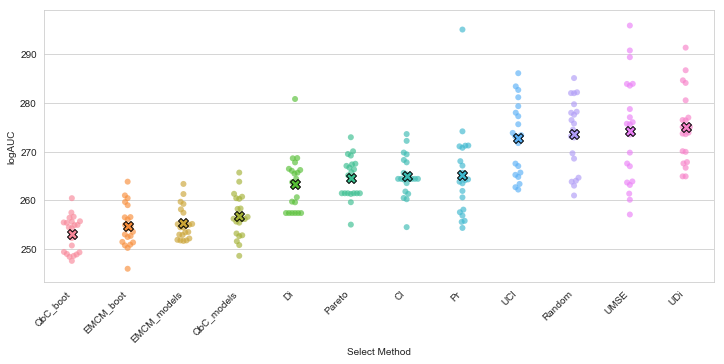

In [97]:
# RF

grouped_summary = summary[summary['Regressor'] == best_regressor].groupby(['Select Method']).agg({'logAUC':'mean'}).reset_index()
methods_order = grouped_summary.sort_values(by='logAUC')['Select Method'].tolist()

fig, ax = plt.subplots(figsize=(25,4.8))
sns.swarmplot(x="Select Method", y="logAUC", data=summary[summary['Regressor'] == best_regressor], order=methods_order, dodge=True, size=6, alpha=0.65, ax=ax)
ax = sns.swarmplot(x="Select Method", y="logAUC", order=methods_order, data=grouped_summary, marker='X', edgecolor='black',dodge=True, linewidth=1, size=10, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.set_size_inches(12,5)
plt.savefig('plots/select_methods_comparison_all.eps', format='eps', bbox_inches = 'tight')

<Figure size 720x288 with 0 Axes>

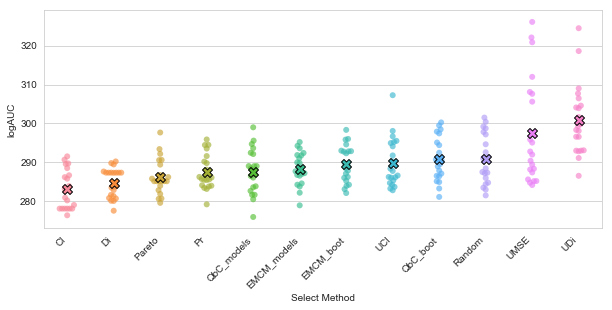

In [38]:
# LR

grouped_summary = summary[summary['Regressor'] == 'LinearRegression'].groupby(['Select Method']).agg({'logAUC':'mean'}).reset_index()
methods_order = grouped_summary.sort_values(by='logAUC')['Select Method'].tolist()

plt.figure(figsize=(10, 4))
fig, ax = plt.subplots(figsize=(25,4.8))
sns.swarmplot(x="Select Method", y="logAUC", data=summary[summary['Regressor'] == 'LinearRegression'], order=methods_order, dodge=True, size=6, alpha=0.65, ax=ax)
ax = sns.swarmplot(x="Select Method", y="logAUC", order=methods_order, data=grouped_summary, marker='X', edgecolor='black',dodge=True, linewidth=1, size=10, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.set_size_inches(10,4)

<Figure size 720x288 with 0 Axes>

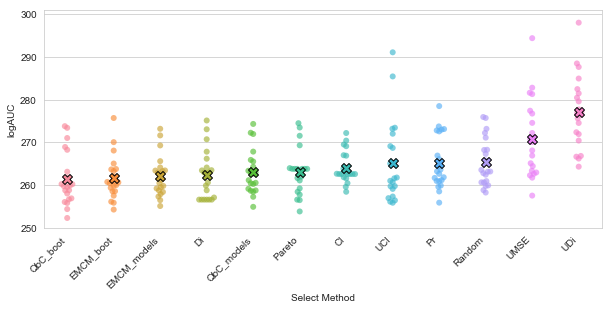

In [39]:
# XGB

grouped_summary = summary[summary['Regressor'] == 'XGBoost'].groupby(['Select Method']).agg({'logAUC':'mean'}).reset_index()
methods_order = grouped_summary.sort_values(by='logAUC')['Select Method'].tolist()

plt.figure(figsize=(10, 4))
fig, ax = plt.subplots(figsize=(25,4.8))
sns.swarmplot(x="Select Method", y="logAUC", data=summary[summary['Regressor'] == 'XGBoost'], order=methods_order, dodge=True, size=6, alpha=0.65, ax=ax)
ax = sns.swarmplot(x="Select Method", y="logAUC", order=methods_order, data=grouped_summary, marker='X', edgecolor='black',dodge=True, linewidth=1, size=10, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.set_size_inches(10,4)

## T-Tests

In [201]:
from scipy.stats import ttest_rel

df2 = df[['Regressor', 'Init Method', 'init_steps', 'Select Method', 'Iter', 'log_MSE']].rename(columns={'init_steps': 'Init Steps'}).copy()

ttests = []

dimensions = {}
dimensions['Regressor'] = df2['Regressor'].unique().tolist()
dimensions['Init Method'] = df2['Init Method'].unique().tolist()
dimensions['Init Steps'] = df2['Init Steps'].unique().tolist()
dimensions['Select Method'] = df2['Select Method'].unique().tolist()

sort_columns = ['Regressor', 'Init Method', 'Init Steps', 'Select Method', 'Iter', 'log_MSE']
df2 = df2.sort_values(by=sort_columns)

In [202]:
# algorithm
p_values = []
dimension1 = 'Regressor'
dimension2 = 'Init Method'
for d11 in dimensions[dimension1]:
    for d12 in dimensions[dimension1]:
        for d21 in dimensions[dimension2]:
            for d22 in dimensions[dimension2]:
                if d11 == d12 and d21 == d22:
                    continue
                sample1 = df2[(df2[dimension1] == d11) & (df2[dimension2] == d21)]
                sample2 = df2[(df2[dimension1] == d12) & (df2[dimension2] == d22)]
                if sample1.shape[0] != sample2.shape[0]:
                    if sample1.shape[0] > sample2.shape[0]:
                        sample2 = pd.concat([sample2] * (sample1.shape[0] // sample2.shape[0])).sort_values(by=sort_columns)
                    elif sample1.shape[0] < sample2.shape[0]:
                        sample1 = pd.concat([sample1] * (sample2.shape[0] // sample1.shape[0])).sort_values(by=sort_columns)
                p_value = ttest_rel(sample1['log_MSE'], sample2['log_MSE'])
                p_values.append({'Dimension1':dimension1, 'Dimension2':dimension2, 'Dimension1_Sample1':d11,
                               'Dimension2_Sample1':d21, 'Dimension1_Sample2':d12, 'Dimension2_Sample2':d22, 'P_value':p_value[1]})
ttests.append(pd.DataFrame(p_values))

In [203]:
# init method

p_values = []
dimension1 = 'Init Method'
dimension2 = 'Init Steps'
for d11 in dimensions[dimension1]:
    for d12 in dimensions[dimension1]:
        for d21 in dimensions[dimension2]:
            for d22 in dimensions[dimension2]:
                if d11 == d12 and d21 == d22:
                    continue
                sample1 = df2[(df2[dimension1] == d11) & (df2[dimension2] == d21) & (df2['Regressor'] == best_regressor)]
                sample2 = df2[(df2[dimension1] == d12) & (df2[dimension2] == d22) & (df2['Regressor'] == best_regressor)]
                if sample1.shape[0] == 0 or sample2.shape[0] == 0:
                    continue
                elif sample1.shape[0] > sample2.shape[0]:
                    sample2 = pd.concat([sample2] * (sample1.shape[0] // sample2.shape[0])).sort_values(by=sort_columns)
                elif sample1.shape[0] < sample2.shape[0]:
                    sample1 = pd.concat([sample1] * (sample2.shape[0] // sample1.shape[0])).sort_values(by=sort_columns)
                p_value = ttest_rel(sample1['log_MSE'], sample2['log_MSE'])
                p_values.append({'Dimension1':dimension1, 'Dimension2':dimension2, 'Dimension1_Sample1':d11,
                               'Dimension2_Sample1':d21, 'Dimension1_Sample2':d12, 'Dimension2_Sample2':d22, 'P_value':p_value[1]})
ttests.append(pd.DataFrame(p_values))

In [204]:
p_values = []
dimension1 = 'Init Method'
for d11 in dimensions[dimension1]:
    for d12 in dimensions[dimension1]:
            if d11 == d12:
                continue
            sample1 = df2[(df2[dimension1] == d11) & (df2['Regressor'] == best_regressor)]
            sample2 = df2[(df2[dimension1] == d12) & (df2['Regressor'] == best_regressor)]
            if sample1.shape[0] != sample2.shape[0]:
                if sample1.shape[0] > sample2.shape[0]:
                    sample2 = pd.concat([sample2] * (sample1.shape[0] // sample2.shape[0])).sort_values(by=sort_columns)
                elif sample1.shape[0] < sample2.shape[0]:
                    sample1 = pd.concat([sample1] * (sample2.shape[0] // sample1.shape[0])).sort_values(by=sort_columns)
            p_value = ttest_rel(sample1['log_MSE'], sample2['log_MSE'])
            p_values.append({'Dimension1':dimension1, 'Dimension2':None, 'Dimension1_Sample1':d11,
                           'Dimension2_Sample1':None, 'Dimension1_Sample2':d12, 'Dimension2_Sample2':None, 'P_value':p_value[1]})
ttests.append(pd.DataFrame(p_values))

In [205]:
# select method

p_values = []
dimension1 = 'Select Method'
for d11 in dimensions[dimension1]:
    for d12 in dimensions[dimension1]:
            if d11 == d12:
                continue
            sample1 = df2[(df2[dimension1] == d11) & (df2['Regressor'] == best_regressor)]
            sample2 = df2[(df2[dimension1] == d12) & (df2['Regressor'] == best_regressor)]
            if sample1.shape[0] != sample2.shape[0]:
                if sample1.shape[0] > sample2.shape[0]:
                    sample2 = pd.concat([sample2] * (sample1.shape[0] // sample2.shape[0])).sort_values(by=sort_columns)
                elif sample1.shape[0] < sample2.shape[0]:
                    sample1 = pd.concat([sample1] * (sample2.shape[0] // sample1.shape[0])).sort_values(by=sort_columns)
            p_value = ttest_rel(sample1['log_MSE'], sample2['log_MSE'])
            p_values.append({'Dimension1':dimension1, 'Dimension2':None, 'Dimension1_Sample1':d11,
                           'Dimension2_Sample1':None, 'Dimension1_Sample2':d12, 'Dimension2_Sample2':None, 'P_value':p_value[1]})
ttests.append(pd.DataFrame(p_values))

In [206]:
# select method for Di-15

p_values = []
dimension1 = 'Select Method'
for d11 in dimensions[dimension1]:
    for d12 in dimensions[dimension1]:
            if d11 == d12:
                continue
            sample1 = df2[(df2[dimension1] == d11) & (df2['Init Method'] == 'Di') & (df2['Init Steps'] == 15) & (df2['Regressor'] == best_regressor)]
            sample2 = df2[(df2[dimension1] == d12) & (df2['Init Method'] == 'Di') & (df2['Init Steps'] == 15) & (df2['Regressor'] == best_regressor)]
            if sample1.shape[0] != sample2.shape[0]:
                if sample1.shape[0] > sample2.shape[0]:
                    sample2 = pd.concat([sample2] * (sample1.shape[0] // sample2.shape[0])).sort_values(by=sort_columns)
                elif sample1.shape[0] < sample2.shape[0]:
                    sample1 = pd.concat([sample1] * (sample2.shape[0] // sample1.shape[0])).sort_values(by=sort_columns)
            p_value = ttest_rel(sample1['log_MSE'], sample2['log_MSE'])
            p_values.append({'Dimension1':dimension1 + '_Di-15', 'Dimension2':None, 'Dimension1_Sample1':d11,
                           'Dimension2_Sample1':None, 'Dimension1_Sample2':d12, 'Dimension2_Sample2':None, 'P_value':p_value[1]})
ttests.append(pd.DataFrame(p_values))

In [207]:
ttests = pd.concat(ttests, axis=0)
ttests.shape

(914, 7)

In [209]:
ttests.to_csv('../data/active_learning/final_results/ttests.csv', index=False)

## Understanding The Features

In [103]:
df['query_idx'] = df['query_idx'].apply(lambda x: eval(x))
dfgb = df.groupby(['Regressor', 'method', 'list_type', 'Initialization', 'Init Method', 'init_steps', 'reg_init_method', 'method_type']).agg({'query_idx':'sum'}).reset_index()

In [122]:
import pickle
with open('../data/active_learning/rf_model.pkl', 'rb') as file:
    model = pickle.load(file)
print(model)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [138]:
# sklearn features importances

list(zip(model.features_names_, model.feature_importances_))

[('DailyActivity', 0.004752524201417543),
 ('DIM', 0.019284579150483764),
 ('CS_CalvingMonth', 0.002450500566673958),
 ('LactationNumber', 0.0008569201180475038),
 ('Age', 0.007537074416522292),
 ('Still', 0.00019686707011698647),
 ('Disease', 0.0006441324943582945),
 ('DailyConductivity', 0.009253636861600172),
 ('DIM_<50', 0.002222667308480901),
 ('DIM_50-175', 0.000307018388390896),
 ('DIM_>=175', 0.00036003102463460883),
 ('FirstLactation', 6.780226544876514e-05),
 ('BCSAtCalving', 0.0016475279416909103),
 ('Fat', 0.020073227143637257),
 ('Protein', 0.024065087551392535),
 ('Lactose', 0.15959673573079022),
 ('LogScc', 0.03385289829651448),
 ('Blood', 0.03501711739186702),
 ('CaseinMeanCalibrated', 0.27866718232996),
 ('MufaMeanCalibrated', 0.048791190847095975),
 ('PufaMeanCalibrated', 0.0613102747439785),
 ('SfaMeanCalibrated', 0.011236591017592305),
 ('UfaMeanCalibrated', 0.007645880837378674),
 ('PaMeanCalibrated', 0.024954096441349594),
 ('SaMeanCalibrated', 0.00663561129636956

In [159]:
import shap

train = pd.read_csv('../data/active_learning/train_data_final_rf.csv')
test = pd.read_csv('../data/active_learning/test_data_final_rf.csv')
train = train.rename(columns={x: x.replace('MeanCalibrated', '') for x in train.columns})
test = test.rename(columns={x: x.replace('MeanCalibrated', '') for x in test.columns})
explainer = shap.TreeExplainer(model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


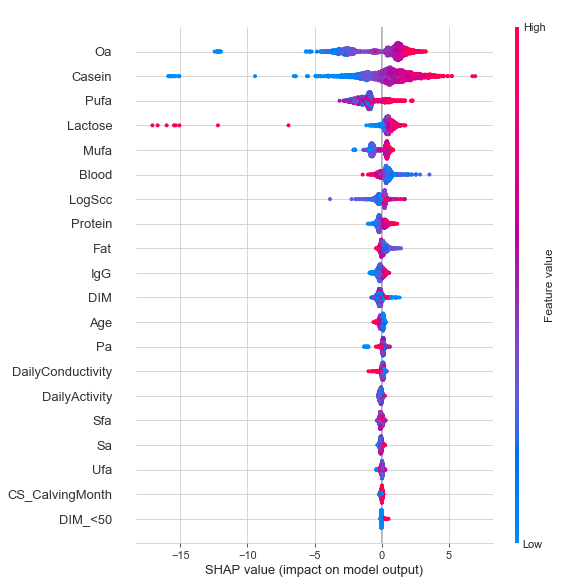

In [160]:
shap_values = explainer.shap_values(test)
shap.summary_plot(shap_values, test, max_display=20)

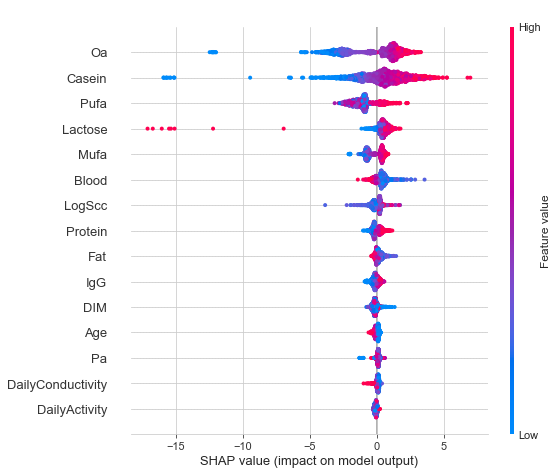

In [235]:
f = shap.summary_plot(shap_values, test, max_display=15, show=False)
plt.savefig('plots/features_shap.png', format='png', bbox_inches = 'tight')

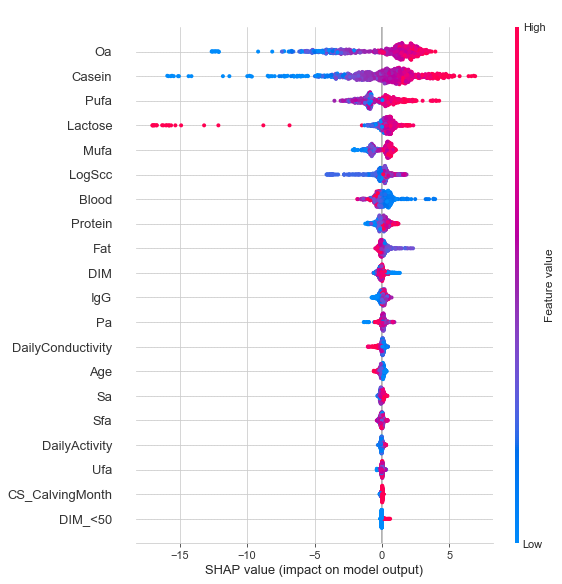

In [155]:
shap_values = explainer.shap_values(train)
shap.summary_plot(shap_values, train, max_display=20, tight)